In [7]:
# https://ai.google.dev/gemini-api/docs/structured-output?lang=python
# https://github.com/langchain-ai/langchain-google/issues/659
# https://github.com/langchain-ai/langchain-google/issues/615

In [1]:
from pydantic import BaseModel, Field

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    #interests: list = Field(description="A list of the user's interests")


In [1]:
from typing import TypedDict

class UserProfile(TypedDict):
    """ Profile of a user """    
    user_name: str #The user's preferred name
    user_location: str #The user's location

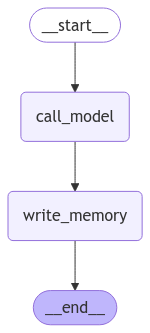

In [2]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_google_vertexai import ChatVertexAI
from trustcall import create_extractor


# Initialize the model
#model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatVertexAI(model="gemini-1.5-flash", temperature=0)
model = ChatVertexAI(model="gemini-1.5-pro-002", temperature=0)


# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [3]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is vikas")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is vikas
================================== Ai Message ==================================

Hi Vikas, it's nice to meet you!  How can I help you today?


In [4]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'vikas', 'user_location': ''},
 'created_at': '2025-02-03T00:49:24.425541+00:00',
 'updated_at': '2025-02-03T00:49:24.425544+00:00'}

In [5]:
# User input 
input_messages = [HumanMessage(content="I like to know about recent events in New Delhi")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to know about recent events in New Delhi


Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring


================================== Ai Message ==================================

Unfortunately, I don't have access to real-time information, including breaking news.  To stay up-to-date on recent events in New Delhi, I recommend checking reputable news sources such as:

* **Major Indian News Outlets:**  NDTV, The Times of India, The Hindu, Hindustan Times, Indian Express
* **International News Outlets:**  BBC News (India section), CNN (India section), Reuters (India), Al Jazeera (India)

You can also use news aggregators like Google News and Apple News, setting your location to New Delhi to prioritize local news.  For specific events or topics, searching on Twitter can also provide real-time updates, but be sure to verify the information from reliable sources.


Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT